# Basic usage and embedding generation with Eva

## Load model and data

In [ ]:
# change work dir
import os

os.chdir("/Your/path/to/Eva")

import matplotlib.pyplot as plt
import numpy as np
import torch
from omegaconf import OmegaConf

from Eva.utils import create_model, extract_features, load_from_hf

In [2]:
%%time
# Load configuration
conf = OmegaConf.load("config.yaml")

# Load model from HuggingFace Hub, will download from HF for the first time
device = "cuda:1" if torch.cuda.is_available() else "cpu"
model = load_from_hf(
    repo_id="yandrewl/Eva",
    conf=conf,
    device=device
)
# print(model)  # check model architecture

Checkpoint downloaded to: /home/yfliu/.cache/huggingface/hub/models--yandrewl--Eva/snapshots/b48e234ef0d17ec6baba0f086188e6e87f3e319b/Eva_model.ckpt
Model loaded successfully from HuggingFace Hub
CPU times: user 11.3 s, sys: 2.53 s, total: 13.8 s
Wall time: 17.5 s


In [3]:
# Load examples of H&E and MIF patches with size of 224*224
mif_patch = np.load("examples/MIF_patch.npy")
he_patch = np.load("examples/HE_patch.npy") / 255.0
biomarkers = np.load("examples/biomarkers.npy", allow_pickle=True).tolist()

print(biomarkers)

['PD1', 'CD163', 'CD44', 'CD34', 'VISTA', 'BCL2', 'GranzymeB', 'ICOS', 'ECad', 'CD11c', 'PCNA', 'Gal3', 'PanCK', 'Vimentin', 'Ki67', 'ATM', 'CD38', 'Keratin8/18', 'ERa', 'CD141', 'CD39', 'CD4', 'aSMA', 'IFNg', 'HLA-E', 'CollagenIV', 'PDL1', 'GATA3', 'DAPI', 'CD31', 'MPO', 'IDO1', 'Caveolin1', 'CD20', 'CD21', 'CD40', 'FoxP3', 'EpCAM', 'HLA-DR', 'LAG3', 'CD3e', 'TIGIT', 'CD8', 'CD45RO', 'TP63', 'CD68', 'CD66', 'CD45', 'Podoplanin', 'CD14', 'HLA-ABC', 'CD79']


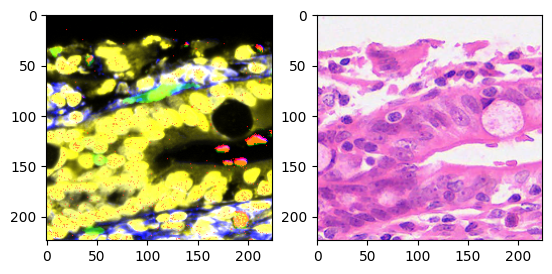

In [4]:
# visualize MIF patch
from utils.overlay import compose_overlay

overlay = compose_overlay(mif_patch, [biomarkers.index("DAPI"), 1, 2, 3 ,4 ], colors=["gray", "red", "blue", "green", "yellow"])  
# here we move DAPI to the first one.
# for check compose_overlay for customized function usage
fig, ax = plt.subplots(1, 2) 
ax[0].imshow(overlay)
ax[1].imshow(he_patch.astype(np.float32))

## Embedding generation with Eva

Note: 

1. Before embedding generation, please download the GenePT marker embeddings from [Zenodo record](https://zenodo.org/records/10833191). Use the file **GenePT_gene_protein_embedding_model_3_text.pickle** and store it as **marker_embeddings/marker_embedding.pkl** locally.

2. `channel_mode` controls multi-modality input. For multi-modal input, append H&E as the last three channels. If the data has only one modality, set `channel_mode="full"`.

In [9]:
%%time
# 1. MIF embedding
features = extract_features(
    patch=torch.from_numpy(mif_patch).unsqueeze(0),  # shape as [B, H, W, C]
    bms=[biomarkers],  # List of biomarker lists (one per batch item)
    model=model,
    device=device,
    cls=False,  # Use CLS token (True) or averaged token (False)
    channel_mode="full"  
)
print(features.shape)

torch.Size([1, 768])
CPU times: user 768 ms, sys: 0 ns, total: 768 ms
Wall time: 27.7 ms


In [11]:
%%time
# 2. MIF with model method
features = model.extract_features(
    patch=torch.from_numpy(mif_patch).unsqueeze(0),
    bms=[biomarkers],
    device=device,
    cls=False, 
    channel_mode="full"
)
print(features.shape)

torch.Size([1, 768])
CPU times: user 720 ms, sys: 552 μs, total: 721 ms
Wall time: 27.9 ms


In [10]:
%%time
# 3. H&E embedding
features = extract_features(
    patch=torch.from_numpy(he_patch).unsqueeze(0),  # shape as [B, H, W, C]
    bms=[["HECHA1", "HECHA2", "HECHA3"]],  # refer to constant for detailed marker names
    device=device,
    model=model,
    cls=False,
    channel_mode="full"
)
print(features.shape)

torch.Size([1, 768])
CPU times: user 478 ms, sys: 0 ns, total: 478 ms
Wall time: 10.9 ms


In [12]:
%%time
# 4. Multi-model embedding
features = extract_features(
    patch=torch.from_numpy(np.concatenate([mif_patch, he_patch], axis=-1)).unsqueeze(0),  
    bms=[biomarkers +["HECHA1", "HECHA2", "HECHA3"]],
    device=device,
    model=model,
    cls=False,
    channel_mode="HE"  # Options: "full", "HE", "MIF", this option determine modality by their ORDER, i.e. the last three are H&E
)
print(features.shape)

torch.Size([1, 768])
CPU times: user 588 ms, sys: 0 ns, total: 588 ms
Wall time: 15.4 ms
